# Model generation from IMC dataset

This Jupyter notebook contains the entire model generation procedure used to construct logistic regression predictors for outcome of Ebola patients. The training data includes 470 patients treated at the ETUs managed by IMC in Liberia and Sierra Leone between 2014 and 2015. Ssee [Skrable (2017)](http://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0005700) for details on this dataset.

Multiple imputation and boostrap validation are used to account for missing data and to produce internal evaluation without spliting the data into separate trainig and validation sets, which decreases model's power.

# Initialization

In [1]:
import pandas as pd
from os import listdir, makedirs
from os.path import isfile, join, exists

# This disables the warnings from RPy2 when R loads libraries that in turn load other dependencies
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

%load_ext rpy2.ipython

In [2]:
%%R

# Load required R libraries

library(rms)
library(Hmisc)
library(glmnet)

In [3]:
%%R 

# Random seed for reproducibility. Is reset at the beginning of each 
# calculating that involves randomization, so cells can be run in 
# arbitrary order and still reproduce results.

random_seed <- 151 

In [4]:
# Data file and modeling prameters
src_data_file = '../data/data.csv'

num_imp = 100   # Number of multiple imputations
num_boot = 200  # Number of bootstrap samples

In [5]:
# Some utility functions in Python

# Replaces PatientAge and FeverTemperature by Restricted Cubic Splines of order 3
def addRCSTerms(model_formula):
    formula = model_formula.replace('PatientAge', 'rcs(PatientAge,3)')
    formula = formula.replace('FeverTemperature', 'rcs(FeverTemperature,3)')    
    return formula

def makeImputeFormula(out_var, pred_vars):
    formula = '~' + '+'.join([out_var] + pred_vars)
    return formula

def makeLogRegFormula(out_var, pred_vars):
    formula = addRCSTerms(out_var + '~' + '+'.join(pred_vars))
    return formula

def createModelFolder(path):    
    if not exists(path):
        makedirs(path)
    return path

In [6]:
%%R 

# Some utility functions in R

# Trims leading and trailing whitespaces
# https://stackoverflow.com/a/21882152
trim <- function(x) {
    return(gsub("(^[[:space:]]+|[[:space:]]+$)", "", x))
}

# Extract single frame from MI data
# https://stackoverflow.com/a/42820029
getImpute <- function(impute, data = src_data, im = 1) {
  cbind.data.frame(impute.transcan(x = impute, 
                                   imputation = im, 
                                   data = data, 
                                   list.out = TRUE, 
                                   pr = FALSE))
}

# Auxiliary (X^3)+
cubic <- function(u) {
   t <- max(0, u)
   return(t * t * t)
}

# Calculates the RCS term given the valuex, the term index, and the knots
rcsFun <- function(x, term, knots) {
    k <- length(knots) 
    j <- term
    t <- knots
    c <- (t[k] - t[1]) * (t[k] - t[1])
    value <- +cubic(x - t[j])
             -cubic(x - t[k - 1]) * (t[k] - t[j])/(t[k] - t[k-1])
             +cubic(x - t[k]) * (t[k - 1] - t[j])/(t[k] - t[k-1]) 
    return(value / c)  
}

# Arrange dataframe vars by position
# 'vars' must be a named vector, e.g. c("var.name"=1)
# https://stackoverflow.com/a/37009127
arrangeVars <- function(data, vars) {
    # Stop if not a data.frame (but should work for matrices as well)
    stopifnot(is.data.frame(data))

    # Sort out inputs
    data.nms <- names(data)
    var.nr <- length(data.nms)
    var.nms <- names(vars)
    var.pos <- vars
    
    # Sanity checks
    stopifnot(!any(duplicated(var.nms)), 
              !any(duplicated(var.pos)))
    stopifnot(is.character(var.nms), 
              is.numeric(var.pos))
    stopifnot(all(var.nms %in% data.nms))
    stopifnot(all(var.pos > 0), 
              all(var.pos <= var.nr))

    # Prepare output
    out.vec <- character(var.nr)
    out.vec[var.pos] <- var.nms
    out.vec[-var.pos] <- data.nms[ !(data.nms %in% var.nms) ]
    stopifnot( length(out.vec)==var.nr )

    # Re-arrange vars by position
    data <- data[, out.vec]
    return(data)
}

saveToTXT <- function(obj, dir, fn) {
    sink(paste0(dir, "/", fn), append=FALSE, split=FALSE)
    print(obj)
    sink()    
}

saveToPDF <- function(obj, dir, fn) {
    pdf(paste0(dir, "/", fn), useDingbats=FALSE)
    plot(obj)
    dev.off()
}

saveModelToCSV <- function(f, vars, dir) {
    terms = names(f$coefficients)
    coeff = unname(f$coefficients)

    # Extract RCS knots from model specs. 
    # This code is now specific to get the knots for age and fever temperature, 
    # but it could be generalized easily by providing a list with all the 
    # variables modeled as RCS.
    
    spec = specs(f)
    # print(str(spec)) # This is useful to understand the structure of the object
    
    ageIdx <- which(vars == "PatientAge")
    tempIdx <- which(vars == "FeverTemperature")
    ageKnots <- spec$how.modeled[ageIdx, 2]
    tempKnots <- spec$how.modeled[tempIdx, 2]
    ageKnots <- trim(ageKnots)
    tempKnots <- trim(tempKnots)

    types <- rep.int("linear", length(terms))
    knots = rep.int("none", length(terms))

    age0 <- which(terms == "PatientAge")
    age1 <- which(terms == "PatientAge'")

    temp0 <- which(terms == "FeverTemperature")
    temp1 <- which(terms == "FeverTemperature'")

    types[age0] <- "RCS0"
    types[age1] <- "RCS1"
    knots[age1] <- ageKnots

    types[temp0] <- "RCS0"
    types[temp1] <- "RCS1"
    knots[temp1] <- tempKnots

    model <- data.frame("Term" = terms, "Coefficient" = coeff, "Type" = types, "Knots" = knots)
    write.table(model, file = paste0(dir, "/model.csv"), sep = ",", row.names=FALSE, qmethod = "double")    
}

saveDescription <- function(f, vars, dir) {
    print(f)
    saveToTXT(f, dir, "model.txt")
    saveToTXT(specs(f), dir, "specs.txt")
    
    saveModelToCSV(f, vars, dir)    
}

saveEvaluation <- function(an, val, cal, dir) {
    print(val)
    plot(cal)

    saveToTXT(an, dir, "anova.txt")
    saveToPDF(an, dir, "anova.pdf")

    saveToTXT(val, dir, "validation.txt")
    saveToPDF(cal, dir, "calibration.pdf")    
}

In [7]:
%%R -i src_data_file

# Load the source data

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

summary_table = data.frame(do.call(cbind, lapply(src_data, summary)))
print(summary_table)

        PatientKey   ETUKey PatientAge PatientSex Disposition     Fever
Min.      23209.00 1.000000    0.01000  0.0000000   0.0000000 0.0000000
1st Qu.   23447.50 1.000000   16.00000  0.0000000   0.0000000 1.0000000
Median    24329.00 2.000000   30.00000  0.0000000   1.0000000 1.0000000
Mean      24265.26 2.478723   30.48386  0.4051173   0.5763441 0.7526652
3rd Qu.   24789.00 4.000000   43.00000  1.0000000   1.0000000 1.0000000
Max.      26109.00 5.000000   80.00000  1.0000000   1.0000000 1.0000000
NA's      23209.00 1.000000    4.00000  1.0000000   5.0000000 1.0000000
        FeverNoDays DaysSinceSymptomOnset DaysSinceSymptomFeverOnset
Min.       0.000000              0.000000                   0.000000
1st Qu.    2.000000              2.000000                   2.000000
Median     3.000000              4.000000                   4.000000
Mean       3.516949              4.286195                   4.232044
3rd Qu.    4.000000              6.000000                   6.000000
Max.      

In [8]:
src_data = pd.read_csv(src_data_file, na_values='\\N')

mdead = len(src_data[src_data['Disposition'] == 1])
msurv = len(src_data[src_data['Disposition'] == 0])

print('Recommended maximum DOF:', str(round(min(mdead, msurv) / 15)))

all_vars = list(src_data.columns.values)

print()
print('All variables in the data:')
print(all_vars)

# Variable we want to predict
out_var = 'Disposition'

all_vars = all_vars[2:all_vars.index('Bleeding') + 1]
all_vars += ['BoneMuscleJointPain', 'malaria1', 'cycletime', 'WellnessScale']

# Remove output variable
all_vars.remove(out_var)

# Remove "problematic" variables: Wellness scale has a lot of NAs, and is highly collinear
# with the combination of the rest of the clinical signs/symptoms, and coma is also missing
# for many cases and in fact there is only one case recorded with coma so it is insufficient
# to draw any conclusion.
for v in ['Coma', 'WellnessScale']: 
    all_vars.remove(v)

print()
print("Variables for modeling:")
print(all_vars)
print(len(all_vars))

Recommended maximum DOF: 13

All variables in the data:
['PatientKey', 'ETUKey', 'PatientAge', 'PatientSex', 'Disposition', 'Fever', 'FeverNoDays', 'DaysSinceSymptomOnset', 'DaysSinceSymptomFeverOnset', 'FeverTemperature', 'Headache', 'Nausea', 'Vomit', 'BloodyVomit', 'Diarrhoea', 'Anorexia', 'Cough', 'ChestPain', 'HaemorrhagicEyes', 'OtherHaemorrhage', 'Breathlessness', 'LossAppetite', 'AstheniaWeakness', 'AbdominalPain', 'Jaundice', 'Throat', 'SwallowingProblems', 'Rash', 'Hiccups', 'Photophobia', 'Confusion', 'Coma', 'Bleeding', 'Gums', 'Stool', 'DigestVomit', 'Vagina', 'Skin', 'Urine', 'EbolaContact', 'Fluids', 'Travel', 'IllInFamily', 'VisitedSomeoneIll', 'SomebodyDiedRecently', 'BeenToFuneral', 'SuspicionEbola', 'PatientPregnant', 'PatientFarAlong', 'PatientHealthcareWorker', 'cycletime1', 'malaria1', 'cycletime2', 'BoneMuscleJointPain', 'BMI', 'cycletime', 'WellnessScale', 'NoSymptoms', 'ReferralTime', 'VomitNausea', 'Headache_R', 'StomachPain_R', 'Weakness_R', 'Anorexia_R', 'Sw

# Saturated model

We begin by fitting a logistic regression model on all the variables.

In [9]:
# Setting the formulas for the imputation and logistic regression fitting of the fully 
# saturated model

sat_vars = all_vars

sat_imp_formula = makeImputeFormula(out_var, sat_vars)
sat_lgr_formula = makeLogRegFormula(out_var, sat_vars)
print(sat_imp_formula)
print(sat_lgr_formula)

sat_folder = createModelFolder('saturated')

~Disposition+PatientAge+PatientSex+Fever+FeverNoDays+DaysSinceSymptomOnset+DaysSinceSymptomFeverOnset+FeverTemperature+Headache+Nausea+Vomit+BloodyVomit+Diarrhoea+Anorexia+Cough+ChestPain+HaemorrhagicEyes+OtherHaemorrhage+Breathlessness+LossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+Throat+SwallowingProblems+Rash+Hiccups+Photophobia+Confusion+Bleeding+BoneMuscleJointPain+malaria1+cycletime
Disposition~rcs(PatientAge,3)+PatientSex+Fever+FeverNoDays+DaysSinceSymptomOnset+DaysSinceSymptomFeverOnset+rcs(FeverTemperature,3)+Headache+Nausea+Vomit+BloodyVomit+Diarrhoea+Anorexia+Cough+ChestPain+HaemorrhagicEyes+OtherHaemorrhage+Breathlessness+LossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+Throat+SwallowingProblems+Rash+Hiccups+Photophobia+Confusion+Bleeding+BoneMuscleJointPain+malaria1+cycletime


In [10]:
%%R -i num_imp,num_boot,sat_imp_formula,sat_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
sat_impute <- aregImpute(as.formula(sat_imp_formula), data=src_data, n.impute=num_imp)
sat_model <- fit.mult.impute(as.formula(sat_lgr_formula), lrm, sat_impute, data=src_data)

# Calculate ANOVA and validation/calibration
sat_anova <- anova(sat_model)
sat_update <- update(sat_model, x=TRUE, y=TRUE)
sat_val <- validate(sat_update, B=num_boot)
sat_cal <- calibrate(sat_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
sat_datadist <- datadist(getImpute(impute = sat_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

                 Intercept                 PatientAge 
                      2.36                       1.38 
               PatientAge'                 PatientSex 
                      1.36                       1.32 
                     Fever                FeverNoDays 
                      1.44                       3.93 
     DaysSinceSymptomOnset DaysSinceSymptomFeverOnset 
                      2.13                       2.31 
          FeverTemperature          FeverTemperature' 
                      2.36                       2.06 
                  Headache                     Nausea 
                      1.26                       2.50 
                     Vomit                BloodyVomit 
                      1.62                       1.01 
                 Diarrhoea                   Anorexia 
                      1.50                       2.90 
                     Cough                  ChestPain 
  

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(sat_lgr_formula), fitter = lrm, 
     xtrans = sat_impute, data = src_data)
 
                      Model Likelihood     Discrimination    Rank Discrim.    
                         Ratio Test           Indexes           Indexes       
 Obs          470    LR chi2     153.65    R2       0.374    C       0.817    
  0           201    d.f.            34    g        1.735    Dxy     0.634    
  1           269    Pr(> chi2) <0.0001    gr       5.737    gamma   0.634    
 max |deriv| 0.05                          gp       0.306    tau-a   0.310    
                                           Brier    0.173                     
 
                            Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept                  12.9724 18.4296  0.70  0.4815  
 PatientAge                 -0.0489  0.0227 -2.16  0.0311  
 PatientAge'                 0.0954  0.0282  3.38  0.0007  
 PatientSex                  0.2712  0.2840  0.95  0.3396  
 

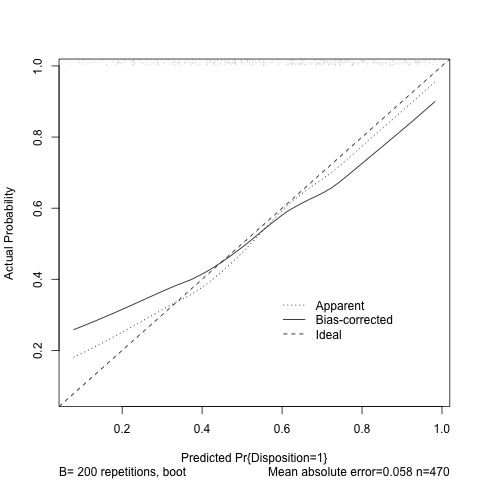

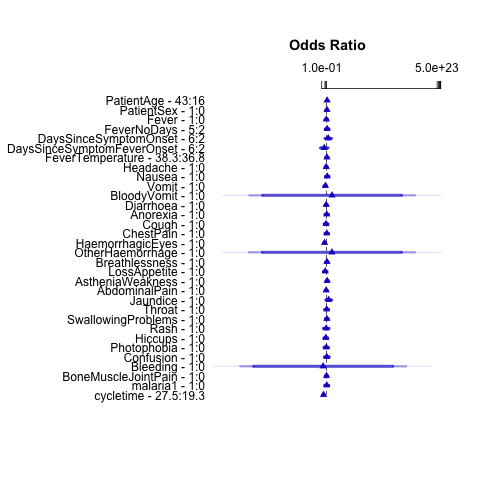

In [11]:
%%R -i sat_folder,sat_vars

# Save the model description and evaluation including coefficients, 
# anova test, bootstrap validation, and calibration

saveDescription(f=sat_model, vars=sat_vars, dir=sat_folder)
saveEvaluation(an=sat_anova, val=sat_val, cal=sat_cal, dir=sat_folder)

# partial effects and ORs for each predictor (cannot be run inside a function for some reason)
options(datadist='sat_datadist')
dir <- sat_folder
df <- getImpute(impute=sat_impute, im=1)
f <- sat_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

The saturated model has a very high C (AUC) on the training data 0.817, however, the boostrap validation shows a very high optimism in the Dxy coefficient of 0.1213. Since C and Dxy are related by C=0.5 + Dxy/2, we have an optimism corrected of 0.71845. This, together with the wide range of ORs for some predictors indicate high overfitting and collinearity of predictors.


# Variable selection with penalized regression

Here we use [Elastic Net Regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization) for variable selection. We run the regularized logistic regression with the [Glmnet package](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) on each imputed dataset, and calculate how many times the coefficient for each variable over all the regressions is greater than zero. 

We are looking for variables that consistenly show non-negative coefficients since they represent clinical signs/symptoms at presentation that should be related with decreased changes of recovery. There are exceptions to this, for example cycletime has a negative coefficient since larger CT values indicate lower viral load and thus higher chances of recovery.

In [12]:
%%R -i num_imp,sat_imp_formula,sat_lgr_formula

rcsAge <- function(x, term) {
    return(rcsFun(x, term, c(5, 30, 58)))
}

rcsTemp <- function(x, term) {
    return(rcsFun(x, term, c(36.3, 37.3, 39.4)))
}

set.seed(random_seed)

# Generate imputed datasets
formula <- as.formula(sat_imp_formula)
imp_data <- aregImpute(formula, data=src_data, n.impute=num_imp)

# Setup the LASSO

# alpha=0 is Ridge Regression (L1 norm penalty only)
# alpha=0.5 is elastic net (mixture of L1 and L2 at a 50%)
# alpha=1 is lasso (L2 norm penalty only)
aelast = 0.5 # actually, we are using the elastic net

# Set binomial as the prediction family so we run logistic regression
predfam = "binomial"

# Iterate over imputations
coeffs <- list()
for (i in 1:num_imp) {
    df <- getImpute(impute = imp_data, im = i)
    
    # Transform the patient age and fever temperature into their RCS terms, that get
    # added to the data frame  
    df$PatientAge1 <- mapply(rcsAge, df$PatientAge, 1)
    df$PatientAge2 <- mapply(rcsAge, df$PatientAge, 2) 
    
    df$FeverTemperature1 <- mapply(rcsTemp, df$FeverTemperature, 1)
    df$FeverTemperature2 <- mapply(rcsTemp, df$FeverTemperature, 2)    
    
    # And remove the original variables 
    drops <- c("PatientAge", "FeverTemperature")
    df <- df[ , !(names(df) %in% drops)]
    
    # Get outcome and predictor variables
    y <- as.matrix(df[,1])    
    x <- as.matrix(df[,2:ncol(df)])
    
    # Finds optimal lambda by cross-validation
    cv <- cv.glmnet(x, y, family=predfam, alpha=aelast, nfolds=10)
    lbest <- cv$lambda.min
    
    # Fit model
    fit <- glmnet(x, y, family=predfam, alpha=aelast, lambda=lbest)

    # Store coefficients  
    coeffs[[i]] <- coef(fit, s = "lambda.min")
}

ncoeff <- length(rownames(coeffs[[1]]))
counts <- list()
for (v in 1:ncoeff) {
    name <- rownames(coeffs[[1]])[v]
    c <- 0.0  
    for (i in 1:num_imp) {
        if (0 < coeffs[[i]][v]) {
            c <- c + 1    
        }
    }
    counts[[name]] <- c/num_imp  
}

# Sorting the counts https://stackoverflow.com/a/30651395
counts <- counts[order(unlist(counts), decreasing=TRUE)]

# And print out...
for (k in names(counts)) {    
    cat(k, counts[[k]], '\n')
}

Iteration 103 
(Intercept) 1 
Jaundice 1 
PatientAge1 1 
PatientAge2 0.99 
Bleeding 0.93 
FeverTemperature1 0.9 
Breathlessness 0.71 
AstheniaWeakness 0.69 
SwallowingProblems 0.66 
malaria1 0.65 
OtherHaemorrhage 0.6 
Confusion 0.56 
FeverNoDays 0.53 
PatientSex 0.5 
Throat 0.44 
ChestPain 0.42 
Anorexia 0.4 
Cough 0.32 
BloodyVomit 0.3 
Nausea 0.28 
FeverTemperature2 0.25 
Photophobia 0.21 
Rash 0.16 
Fever 0.07 
DaysSinceSymptomOnset 0.06 
Diarrhoea 0.01 
Hiccups 0.01 
BoneMuscleJointPain 0.01 
DaysSinceSymptomFeverOnset 0 
Headache 0 
Vomit 0 
HaemorrhagicEyes 0 
LossAppetite 0 
AbdominalPain 0 
cycletime 0 


We set the threshold for keeping a variable at +50% in the above list, meaning that the corresponding regression coefficient had to be positive at least in half of the models to be selected. As mentined CT has a negative coefficient, and patient age and fever temperature are pre-determined, so we will only look at sign/symptoms above that threshold:

In [13]:
%%R

# These are predetermined, or not a model variable (i.e.: the intercept)
exlude = c('(Intercept)', 'PatientAge1', 'PatientAge2', 'FeverTemperature1', 'FeverTemperature2', 'FeverNoDays')

cat("Variables to keep:\n\n")

for (k in names(counts)) {       
    if (!(k %in% exlude) & (counts[[k]] > 0.5)) {
        cat(k, counts[[k]], '\n')
    }
}

Variables to keep:

Jaundice 1 
Bleeding 0.93 
Breathlessness 0.71 
AstheniaWeakness 0.69 
SwallowingProblems 0.66 
malaria1 0.65 
OtherHaemorrhage 0.6 
Confusion 0.56 


Based on this ranking, and following the contained in [Hartley (2017)](http://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0005265) with regards to the factors that prognosticate mortality in Ebola:

> Several studies have already identified single symptoms statistically predictive for EVD mortality, such as confusion (15–17), diarrhoea,(16, 18) asthenia (15, 18), hiccups (14), haemorrhagic signs (14, 16, 19), dizziness (18), extreme fatigue (15), and high viral load (14, 17, 18, 20).

> 14. Hunt L, Gupta-Wright A, Simms V, Tamba F, Knott V, Tamba K, et al. Clinical presentation, biochemical, and haematological parameters and their association with outcome in patients with Ebola virus disease: an observational cohort study. The Lancet Infectious diseases. 2015 Nov;15(11):1292–9. pmid:26271406
> 15. Qin E, Bi J, Zhao M, Wang Y, Guo T, Yan T, et al. Clinical Features of Patients With Ebola Virus Disease in Sierra Leone. Clinical infectious diseases: an official publication of the Infectious Diseases Society of America. 2015 Aug 15;61(4):491–5.
> 16. WHO Ebola Response Team. Ebola virus disease in West Africa—the first 9 months of the epidemic and forward projections. The New England journal of medicine. 2014 Oct 16;371(16):1481–95. Pubmed Central PMCID: 4235004. pmid:25244186
> 17. Zhang X, Rong Y, Sun L, Liu L, Su H, Zhang J, et al. Prognostic Analysis of Patients with Ebola Virus Disease. PLoS neglected tropical diseases. 2015 Sep;9(9):e0004113. Pubmed Central PMCID: 4580459. pmid:26398207
> 18. Schieffelin JS, Shaffer JG, Goba A, Gbakie M, Gire SK, Colubri A, et al. Clinical illness and outcomes in patients with Ebola in Sierra Leone. The New England journal of medicine. 2014 Nov 27;371(22):2092–100. Pubmed Central PMCID: 4318555. pmid:25353969
> 19. Barry M, Traore FA, Sako FB, Kpamy DO, Bah EI, Poncin M, et al. Ebola outbreak in Conakry, Guinea: epidemiological, clinical, and outcome features. Medecine et maladies infectieuses. 2014 Dec;44(11–12):491–4. pmid:25391486
> 20. de La Vega MA, Caleo G, Audet J, Qiu X, Kozak RA, Brooks JI, et al. Ebola viral load at diagnosis associates with patient outcome and outbreak evolution. The Journal of clinical investigation. 2015 Dec;125(12):4421–8. Pubmed Central PMCID: 4665775. pmid:26551677

Here, we considered since bleeding includes all cases of haemorrhage, then OtherHaemorrhage is not needed, and SwallowingProblems does not is very informative of seriousness of illness. Although diaorrhea has been reported in several studies as correlated to outcome in univariate analyses, here is discarded since it does not appear to be a positive constributor to mortality risk in the multivariate models.

# Parsimonious model

This is the model informed by the regularization above, and the expert knowledge from past studies. It includes RCS terms for age and fever, and linear terms for cycletime, malaria, jaundice, bleeding, asthenia/weakness, and confusion. The binary variable fever is included in the imputation since it has less missing values than fever temperature, but we decided it is better to include the latter in the predictive model to avoid discretization issues.

In [43]:
pars_vars = ['PatientAge', 'cycletime', 'malaria1', 'Fever', 'FeverTemperature',                 
             'Jaundice', 'Bleeding', 'Breathlessness', 'AstheniaWeakness', 'Confusion']

pars_imp_formula = makeImputeFormula(out_var, pars_vars)
pars_vars.remove('Fever')
pars_lgr_formula = makeLogRegFormula(out_var, pars_vars)
print(pars_imp_formula)
print(pars_lgr_formula)

pars_folder = createModelFolder('parsimonious')

~Disposition+PatientAge+cycletime+malaria1+Fever+FeverTemperature+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Confusion
Disposition~rcs(PatientAge,3)+cycletime+malaria1+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Confusion


In [44]:
%%R -i num_imp,num_boot,pars_imp_formula,pars_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
pars_impute <- aregImpute(as.formula(pars_imp_formula), data=src_data, n.impute=num_imp)
pars_model <- fit.mult.impute(as.formula(pars_lgr_formula), lrm, pars_impute, data=src_data)

# Calculate ANOVA and validation/calibration
pars_anova <- anova(pars_model)
pars_update <- update(pars_model, x=TRUE, y=TRUE)
pars_val <- validate(pars_update, B=num_boot)
pars_cal <- calibrate(pars_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
pars_datadist <- datadist(getImpute(impute = pars_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'         cycletime 
             2.26              1.21              1.19              1.67 
         malaria1  FeverTemperature FeverTemperature'          Jaundice 
             2.30              2.25              1.84              1.13 
         Bleeding    Breathlessness  AstheniaWeakness         Confusion 
             1.11              1.14              1.15              1.85 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'         cycletime 
             0.56              0.17              0.16              0.40 
         malaria1  FeverTemperature FeverTemperature'          Jaundice 
             0.57              0.56              0.46              0.12 
         Bleeding    Breathlessness  AstheniaWeakness         Confusion 
             0.10              0.13              0.13              0.46 

d.f. for t-distribution for T

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(pars_lgr_formula), fitter = lrm, 
     xtrans = pars_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2     124.22    R2       0.312    C       0.790    
  0            199    d.f.            11    g        1.464    Dxy     0.580    
  1            271    Pr(> chi2) <0.0001    gr       4.351    gamma   0.580    
 max |deriv| 8e-09                          gp       0.277    tau-a   0.284    
                                            Brier    0.186                     
 
                   Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept          7.8685 15.3217  0.51  0.6076  
 PatientAge        -0.0482  0.0184 -2.62  0.0088  
 PatientAge'        0.0934  0.0232  4.02  <0.0001 
 cycletime         -0.1541  0.0270 -5.70  <0.0001 
 malaria1           0.2728  0.4506  0

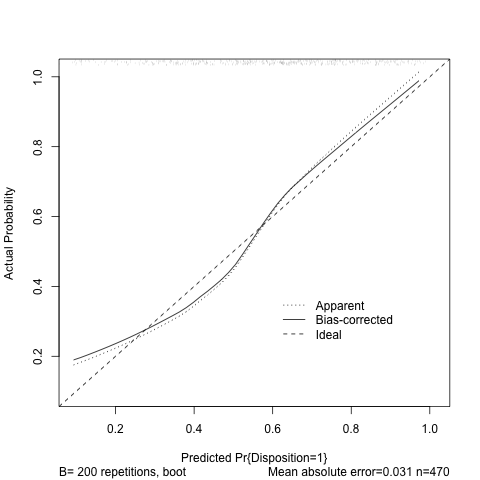

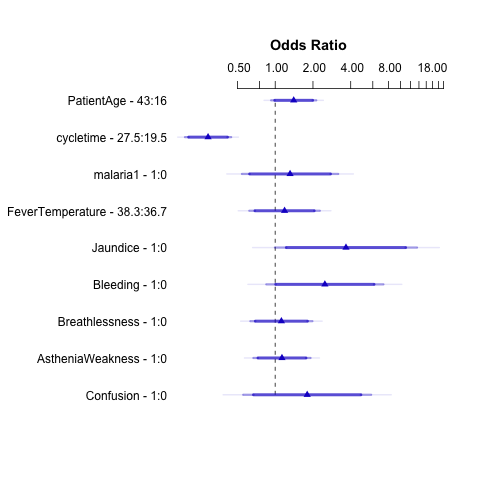

In [45]:
%%R -i pars_folder,pars_vars

saveDescription(f=pars_model, vars=pars_vars, dir=pars_folder)
saveEvaluation(an=pars_anova, val=pars_val, cal=pars_cal, dir=pars_folder)

options(datadist='pars_datadist')
dir <- pars_folder
df <- getImpute(impute=pars_impute, im=1)
f <- pars_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

# Minimal model

The minimal model only includes age and cyletime, which have been identified as the most important predictors of death in Ebola. It represents a baselinea agains which to compare any more complex model to.

In [23]:
min_vars = ['PatientAge', 'cycletime']

min_imp_formula = makeImputeFormula(out_var, min_vars)
min_lgr_formula = makeLogRegFormula(out_var, min_vars)
print(min_imp_formula)
print(min_lgr_formula)

min_folder = createModelFolder('minimal')

~Disposition+PatientAge+cycletime
Disposition~rcs(PatientAge,3)+cycletime


In [24]:
%%R -i num_imp,num_boot,min_imp_formula,min_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
min_impute <- aregImpute(as.formula(min_imp_formula), data=src_data, n.impute=num_imp)
min_model <- fit.mult.impute(as.formula(min_lgr_formula), lrm, min_impute, data=src_data)

# Calculate ANOVA and validation/calibration
min_anova <- anova(min_model)
min_update <- update(min_model, x=TRUE, y=TRUE)
min_val <- validate(min_update, B=num_boot)
min_cal <- calibrate(min_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
min_datadist <- datadist(getImpute(impute = min_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

  Intercept  PatientAge PatientAge'   cycletime 
       1.52        1.15        1.16        1.65 

Rate of Missing Information:

  Intercept  PatientAge PatientAge'   cycletime 
       0.34        0.13        0.14        0.39 

d.f. for t-distribution for Tests of Single Coefficients:

  Intercept  PatientAge PatientAge'   cycletime 
     849.11     5703.36     5006.81      640.87 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

  Intercept  PatientAge PatientAge'   cycletime 
       1.52        1.15        1.16        1.65 

Rate of Missing Information:

  Intercept  PatientAge PatientAge'   cycletime 
       0.34        0.13        0.14        0.39 

d.f. for t-distribution for Tests of Single Coefficients:

  Intercept  PatientAge PatientAge'   cycletime 
     849.11     5703.36     5006.81      640.87 

The following fit co

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(min_lgr_formula), fitter = lrm, 
     xtrans = min_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2     101.61    R2       0.261    C       0.767    
  0            200    d.f.             3    g        1.265    Dxy     0.533    
  1            270    Pr(> chi2) <0.0001    gr       3.560    gamma   0.533    
 max |deriv| 2e-06                          gp       0.250    tau-a   0.261    
                                            Brier    0.197                     
 
             Coef    S.E.   Wald Z Pr(>|Z|)
 Intercept    4.6003 0.7092  6.49  <0.0001 
 PatientAge  -0.0500 0.0161 -3.11  0.0019  
 PatientAge'  0.0939 0.0214  4.38  <0.0001 
 cycletime   -0.1584 0.0260 -6.09  <0.0001 
 
          index.orig training   test optimism index.corrected   n
Dxy   

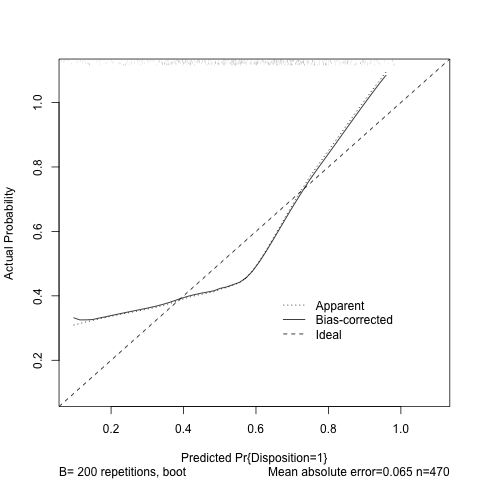

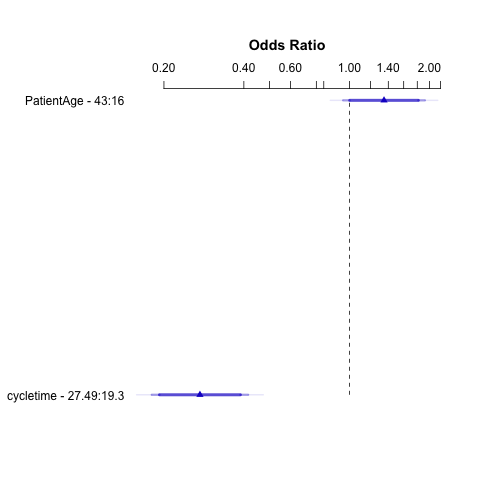

In [25]:
%%R -i min_folder,min_vars

saveDescription(f=min_model, vars=min_vars, dir=min_folder)
saveEvaluation(an=min_anova, val=min_val, cal=min_cal, dir=min_folder)

options(datadist='min_datadist')
dir <- min_folder
df <- getImpute(impute=min_impute, im=1)
f <- min_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

# Additional models

To augment the coverage of the parsimonious and minimal models in situations when other combination of data are available, we have defined a number of additional models:

1. Parsimonious - malaria: This model has the same predictors as the parsimonious, with the exception of the malaria test. This allows making predictions when this test has not been done in the lab.

2. Clinical-only: This model is obtained from the parsimonious after removing the lab tests (CT and malaria) and adding diarrhoea.

Even though predictive value imputation, which refers to imputing missing values at prediction time using the data distribution from the training set and other methods, is the preferred approach to handle this situation, reduced-models approaches, consisting in generating reduced predictive models in advance and seldom mentioned or used, consistently outperforms predictive value imputation according to [Saar-Tsechansky (2007)](http://jmlr.csail.mit.edu/papers/volume8/saar-tsechansky07a/saar-tsechansky07a.pdf).

## Parsimonious - malaria

In [40]:
pmal_vars = ['PatientAge', 'cycletime', 'Fever', 'FeverTemperature',                 
             'Jaundice', 'Bleeding', 'Breathlessness', 'AstheniaWeakness', 'Confusion']

pmal_imp_formula = makeImputeFormula(out_var, pmal_vars)
pmal_vars.remove('Fever')
pmal_lgr_formula = makeLogRegFormula(out_var, pmal_vars)
print(pmal_imp_formula)
print(pmal_lgr_formula)

pmal_folder = createModelFolder('parsimonious-malaria')

~Disposition+PatientAge+cycletime+Fever+FeverTemperature+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Confusion
Disposition~rcs(PatientAge,3)+cycletime+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Confusion


In [41]:
%%R -i num_imp,num_boot,pmal_imp_formula,pmal_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
pmal_impute <- aregImpute(as.formula(pmal_imp_formula), data=src_data, n.impute=num_imp)
pmal_model <- fit.mult.impute(as.formula(pmal_lgr_formula), lrm, pmal_impute, data=src_data)

# Calculate ANOVA and validation/calibration
pmal_anova <- anova(pmal_model)
pmal_update <- update(pmal_model, x=TRUE, y=TRUE)
pmal_val <- validate(pmal_update, B=num_boot)
pmal_cal <- calibrate(pmal_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
pmal_datadist <- datadist(getImpute(impute = pmal_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'         cycletime 
             2.21              1.19              1.17              1.56 
 FeverTemperature FeverTemperature'          Jaundice          Bleeding 
             2.21              1.88              1.10              1.14 
   Breathlessness  AstheniaWeakness         Confusion 
             1.11              1.19              2.28 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'         cycletime 
             0.55              0.16              0.15              0.36 
 FeverTemperature FeverTemperature'          Jaundice          Bleeding 
             0.55              0.47              0.09              0.12 
   Breathlessness  AstheniaWeakness         Confusion 
             0.10              0.16              0.56 

d.f. for t-distribution for Tests of Single Coefficients:

        Intercept        PatientAge       

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(pmal_lgr_formula), fitter = lrm, 
     xtrans = pmal_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2     125.49    R2       0.314    C       0.791    
  0            201    d.f.            10    g        1.475    Dxy     0.582    
  1            269    Pr(> chi2) <0.0001    gr       4.404    gamma   0.582    
 max |deriv| 4e-08                          gp       0.278    tau-a   0.285    
                                            Brier    0.185                     
 
                   Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept          7.8833 15.8747  0.50  0.6195  
 PatientAge        -0.0517  0.0174 -2.98  0.0029  
 PatientAge'        0.0966  0.0226  4.27  <0.0001 
 cycletime         -0.1563  0.0263 -5.95  <0.0001 
 FeverTemperature  -0.1026  0.4282 -0

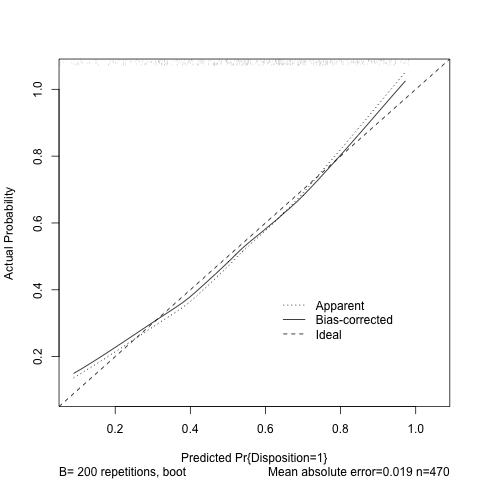

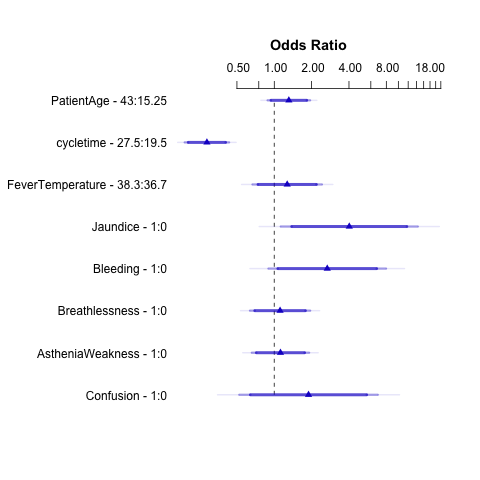

In [42]:
%%R -i pmal_folder,pmal_vars

saveDescription(f=pmal_model, vars=pmal_vars, dir=pmal_folder)
saveEvaluation(an=pmal_anova, val=pmal_val, cal=pmal_cal, dir=pmal_folder)

options(datadist='pmal_datadist')
dir <- pmal_folder
df <- getImpute(impute=pmal_impute, im=1)
f <- pmal_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

## Clinical-only

In [36]:
clin_vars = ['PatientAge', 'Fever', 'FeverTemperature',                 
             'Jaundice', 'Bleeding', 'Breathlessness', 'AstheniaWeakness', 'Diarrhoea', 'Confusion']

clin_imp_formula = makeImputeFormula(out_var, clin_vars)
clin_vars.remove('Fever')
clin_lgr_formula = makeLogRegFormula(out_var, clin_vars)
print(clin_imp_formula)
print(clin_lgr_formula)

clin_folder = createModelFolder('clinical-only')

~Disposition+PatientAge+Fever+FeverTemperature+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Diarrhoea+Confusion
Disposition~rcs(PatientAge,3)+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Diarrhoea+Confusion


In [37]:
%%R -i num_imp,num_boot,clin_imp_formula,clin_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
clin_impute <- aregImpute(as.formula(clin_imp_formula), data=src_data, n.impute=num_imp)
clin_model <- fit.mult.impute(as.formula(clin_lgr_formula), lrm, clin_impute, data=src_data)

# Calculate ANOVA and validation/calibration
clin_anova <- anova(clin_model)
clin_update <- update(clin_model, x=TRUE, y=TRUE)
clin_val <- validate(clin_update, B=num_boot)
clin_cal <- calibrate(clin_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
clin_datadist <- datadist(getImpute(impute = clin_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             2.26              1.12              1.12              2.26 
FeverTemperature'          Jaundice          Bleeding    Breathlessness 
             1.94              1.03              1.06              1.10 
 AstheniaWeakness         Diarrhoea         Confusion 
             1.06              1.14              2.06 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             0.56              0.11              0.11              0.56 
FeverTemperature'          Jaundice          Bleeding    Breathlessness 
             0.48              0.03              0.06              0.09 
 AstheniaWeakness         Diarrhoea         Confusion 
             0.06              0.12              0.52 

d.f. for t-distribution for Tests of Single Coefficients:

        Intercept        PatientAge       

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(clin_lgr_formula), fitter = lrm, 
     xtrans = clin_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2      57.11    R2       0.154    C       0.692    
  0            197    d.f.            10    g        0.892    Dxy     0.384    
  1            273    Pr(> chi2) <0.0001    gr       2.449    gamma   0.384    
 max |deriv| 1e-05                          gp       0.189    tau-a   0.188    
                                            Brier    0.217                     
 
                   Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept          2.1052 14.9804  0.14  0.8882  
 PatientAge        -0.0506  0.0155 -3.28  0.0011  
 PatientAge'        0.0830  0.0202  4.11  <0.0001 
 FeverTemperature  -0.0527  0.4051 -0.13  0.8964  
 FeverTemperature'  0.5273  0.6689  0

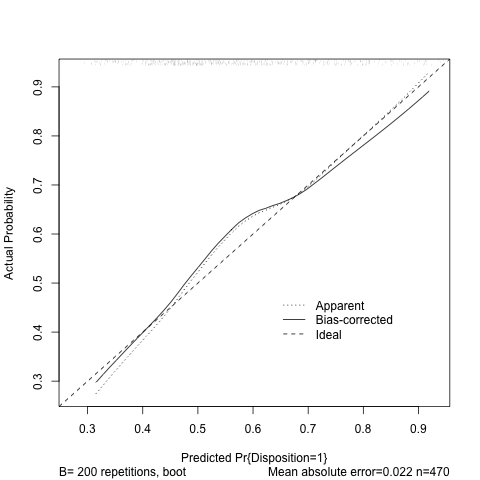

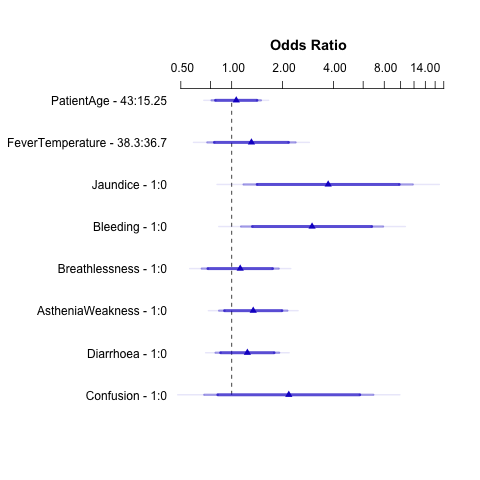

In [48]:
%%R -i clin_folder,clin_vars

saveDescription(f=clin_model, vars=clin_vars, dir=clin_folder)
saveEvaluation(an=clin_anova, val=clin_val, cal=clin_cal, dir=clin_folder)

options(datadist='clin_datadist')
dir <- clin_folder
df <- getImpute(impute=clin_impute, im=1)
f <- clin_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

# Wellness scale

The wellness scale variable in an observational assessment of patient wellness assigned by the physician or physician assistants, and ranges from 0 (cured) to 5 (very sick patient), as detailed below:

0. Cured			
1. Well: no symptoms: drinks and eats okay    
2. Few symptoms: drinks and eats okay	
3. Moderate symptoms: can walk, sit, and feed self      
4. Sick: needs help to be fed, drink, and take medications     
5. Very sick: needs IV fluids and medications, lots of help

The wellness scale was recorded at every daily round, but for the purposes of the prognosis modeling we only considered the wellness from the first rounding. It is also important to note that WS was recorded only at the ETUs in Sierra Leone. This variable is very interesting because it represents a holistic health score that aggregates objective symptoms and perhaps other indications observed by the physicians that are harder to quantify precisely.

So in order to quantify the impact of the wellness scale in predicting outcome, we constructed a two additional models that incorporate this variable:

1. minimal + wellness
2. wellness-only (age, fever temperature and wellness scale instead of any other sign/symptom)
3. wellness + lab (cycletime, malaria) + fever temperature

## Minimal + wellness

In [49]:
mwell_vars = ['PatientAge', 'cycletime', 'WellnessScale']

mwell_imp_formula = makeImputeFormula(out_var, mwell_vars)
mwell_lgr_formula = makeLogRegFormula(out_var, mwell_vars)
print(mwell_imp_formula)
print(mwell_lgr_formula)

mwell_folder = createModelFolder('minimal+wellness')

~Disposition+PatientAge+cycletime+WellnessScale
Disposition~rcs(PatientAge,3)+cycletime+WellnessScale


In [50]:
%%R -i num_imp,num_boot,mwell_imp_formula,mwell_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
mwell_impute <- aregImpute(as.formula(mwell_imp_formula), data=src_data, n.impute=num_imp)
mwell_model <- fit.mult.impute(as.formula(mwell_lgr_formula), lrm, mwell_impute, data=src_data)

# Calculate ANOVA and validation/calibration
mwell_anova <- anova(mwell_model)
mwell_update <- update(mwell_model, x=TRUE, y=TRUE)
mwell_val <- validate(mwell_update, B=num_boot)
mwell_cal <- calibrate(mwell_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
mwell_datadist <- datadist(getImpute(impute = mwell_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         1.98          1.15          1.17          1.79          2.28 

Rate of Missing Information:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         0.49          0.13          0.14          0.44          0.56 

d.f. for t-distribution for Tests of Single Coefficients:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
       406.22       6091.38       4794.56        509.64        313.33 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         1.98          1.15          1.17          1.79          2.28 

Rate of Missing Information:

    Intercept    PatientAge   PatientAge'     cycletime WellnessScale 
         0.49          0.13   

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(mwell_lgr_formula), fitter = lrm, 
     xtrans = mwell_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2     122.30    R2       0.307    C       0.785    
  0            200    d.f.             4    g        1.447    Dxy     0.570    
  1            270    Pr(> chi2) <0.0001    gr       4.279    gamma   0.570    
 max |deriv| 1e-09                          gp       0.275    tau-a   0.279    
                                            Brier    0.188                     
 
               Coef    S.E.   Wald Z Pr(>|Z|)
 Intercept      2.5686 1.0658  2.41  0.0159  
 PatientAge    -0.0477 0.0164 -2.91  0.0036  
 PatientAge'    0.0904 0.0218  4.14  <0.0001 
 cycletime     -0.1326 0.0289 -4.59  <0.0001 
 WellnessScale  0.5049 0.1906  2.65  0.0081  
 
          in

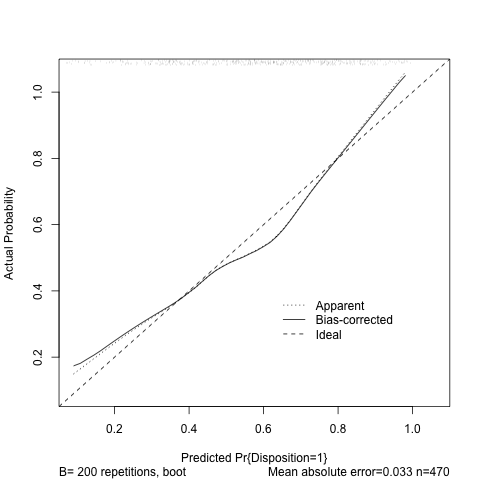

In [51]:
%%R -i mwell_folder,mwell_vars

saveDescription(f=mwell_model, vars=mwell_vars, dir=mwell_folder)
saveEvaluation(an=mwell_anova, val=mwell_val, cal=mwell_cal, dir=mwell_folder)

options(datadist='mwell_datadist')
dir <- mwell_folder
df <- getImpute(impute=mwell_impute, im=1)
f <- mwell_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

## Wellness-only

In [52]:
well_vars = ['PatientAge', 'Fever', 'FeverTemperature', 'WellnessScale']

well_imp_formula = makeImputeFormula(out_var, well_vars)
well_vars.remove('Fever')
well_lgr_formula = makeLogRegFormula(out_var, well_vars)
print(well_imp_formula)
print(well_lgr_formula)

well_folder = createModelFolder('wellness-only')

~Disposition+PatientAge+Fever+FeverTemperature+WellnessScale
Disposition~rcs(PatientAge,3)+rcs(FeverTemperature,3)+WellnessScale


In [53]:
%%R -i num_imp,num_boot,well_imp_formula,well_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
well_impute <- aregImpute(as.formula(well_imp_formula), data=src_data, n.impute=num_imp)
well_model <- fit.mult.impute(as.formula(well_lgr_formula), lrm, well_impute, data=src_data)

# Calculate ANOVA and validation/calibration
well_anova <- anova(well_model)
well_update <- update(well_model, x=TRUE, y=TRUE)
well_val <- validate(well_update, B=num_boot)
well_cal <- calibrate(well_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
well_datadist <- datadist(getImpute(impute = well_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             1.92              1.20              1.20              1.92 
FeverTemperature'     WellnessScale 
             2.10              2.13 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
             0.48              0.17              0.16              0.48 
FeverTemperature'     WellnessScale 
             0.52              0.53 

d.f. for t-distribution for Tests of Single Coefficients:

        Intercept        PatientAge       PatientAge'  FeverTemperature 
           432.62           3615.20           3693.11            431.71 
FeverTemperature'     WellnessScale 
           361.49            352.76 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 


Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge     

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(well_lgr_formula), fitter = lrm, 
     xtrans = well_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2      84.86    R2       0.221    C       0.732    
  0            199    d.f.             5    g        1.136    Dxy     0.465    
  1            271    Pr(> chi2) <0.0001    gr       3.146    gamma   0.465    
 max |deriv| 5e-06                          gp       0.230    tau-a   0.228    
                                            Brier    0.205                     
 
                   Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept         12.1684 13.9740  0.87  0.3839  
 PatientAge        -0.0451  0.0160 -2.82  0.0049  
 PatientAge'        0.0774  0.0209  3.70  0.0002  
 FeverTemperature  -0.3728  0.3793 -0.98  0.3256  
 FeverTemperature'  0.6445  0.5037  1

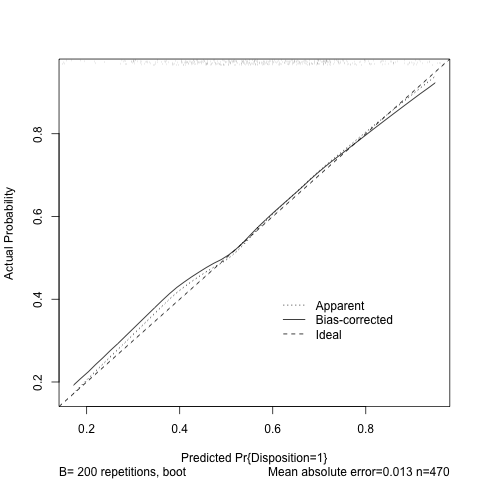

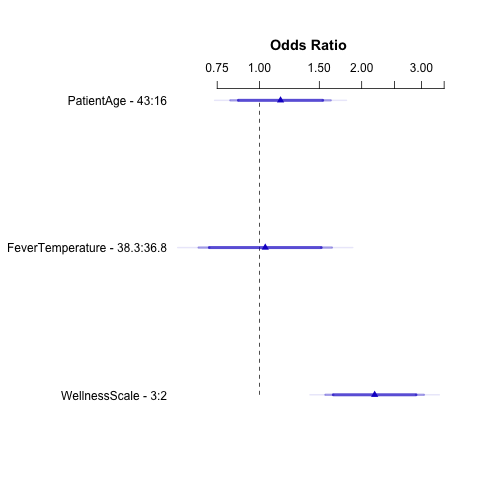

In [54]:
%%R -i well_folder,well_vars

saveDescription(f=well_model, vars=well_vars, dir=well_folder)
saveEvaluation(an=well_anova, val=well_val, cal=well_cal, dir=well_folder)

options(datadist='well_datadist')
dir <- well_folder
df <- getImpute(impute=well_impute, im=1)
f <- well_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

## Wellness + lab + temperature

In [55]:
wlab_vars = ['PatientAge', 'cycletime', 'malaria1','Fever', 'FeverTemperature', 'WellnessScale']

wlab_imp_formula = makeImputeFormula(out_var, wlab_vars)
wlab_vars.remove('Fever')
wlab_lgr_formula = makeLogRegFormula(out_var, wlab_vars)
print(wlab_imp_formula)
print(wlab_lgr_formula)

wlab_folder = createModelFolder('wellness-lab')

~Disposition+PatientAge+cycletime+malaria1+Fever+FeverTemperature+WellnessScale
Disposition~rcs(PatientAge,3)+cycletime+malaria1+rcs(FeverTemperature,3)+WellnessScale


In [56]:
%%R -i num_imp,num_boot,wlab_imp_formula,wlab_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
wlab_impute <- aregImpute(as.formula(wlab_imp_formula), data=src_data, n.impute=num_imp)
wlab_model <- fit.mult.impute(as.formula(wlab_lgr_formula), lrm, wlab_impute, data=src_data)

# Calculate ANOVA and validation/calibration
wlab_anova <- anova(wlab_model)
wlab_update <- update(wlab_model, x=TRUE, y=TRUE)
wlab_val <- validate(wlab_update, B=num_boot)
wlab_cal <- calibrate(wlab_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
wlab_datadist <- datadist(getImpute(impute = wlab_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

        Intercept        PatientAge       PatientAge'         cycletime 
             2.10              1.17              1.14              1.67 
         malaria1  FeverTemperature FeverTemperature'     WellnessScale 
             2.05              2.13              1.95              2.14 

Rate of Missing Information:

        Intercept        PatientAge       PatientAge'         cycletime 
             0.52              0.14              0.13              0.40 
         malaria1  FeverTemperature FeverTemperature'     WellnessScale 
             0.51              0.53              0.49              0.53 

d.f. for t-distribution for Tests of Single Coefficients:

        Intercept        PatientAge       PatientAge'         cycletime 
           361.79           4822.18           6214.10            615.97 
         malaria1  FeverTemperature FeverTemperature'     WellnessScale 
           375.77            351.14        

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(wlab_lgr_formula), fitter = lrm, 
     xtrans = wlab_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2     128.81    R2       0.322    C       0.794    
  0            200    d.f.             7    g        1.492    Dxy     0.587    
  1            270    Pr(> chi2) <0.0001    gr       4.483    gamma   0.587    
 max |deriv| 3e-07                          gp       0.282    tau-a   0.287    
                                            Brier    0.184                     
 
                   Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept          9.7865 14.4698  0.68  0.4988  
 PatientAge        -0.0407  0.0175 -2.32  0.0201  
 PatientAge'        0.0831  0.0222  3.74  0.0002  
 cycletime         -0.1270  0.0280 -4.53  <0.0001 
 malaria1           0.3430  0.4181  0

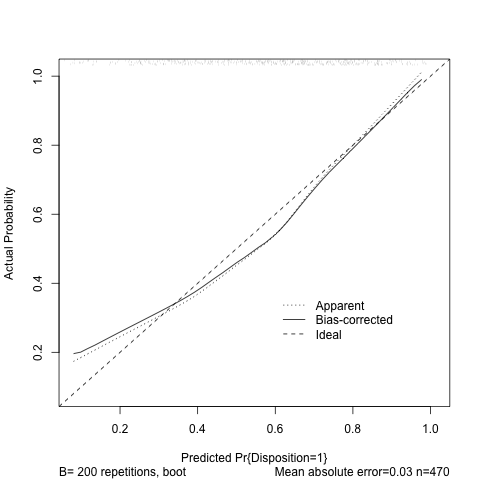

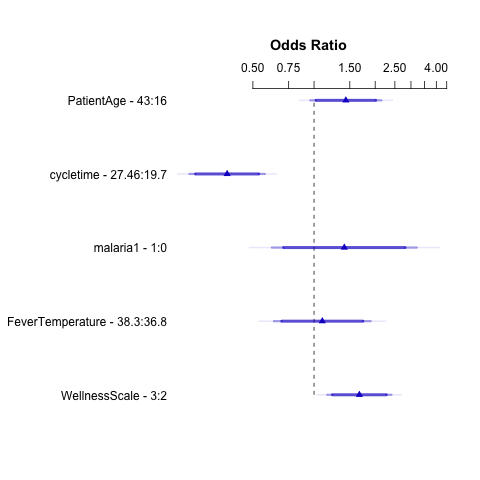

In [57]:
%%R -i wlab_folder,wlab_vars

saveDescription(f=wlab_model, vars=wlab_vars, dir=wlab_folder)
saveEvaluation(an=wlab_anova, val=wlab_val, cal=wlab_cal, dir=wlab_folder)

options(datadist='wlab_datadist')
dir <- wlab_folder
df <- getImpute(impute=wlab_impute, im=1)
f <- wlab_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

If we compare the parsimonious model with the wellness models that include at least CT, we can see that the performance of the second group is very good. Specficically, Dxy=0.5820 and R2=0.2636 compare with Dxy=0.5501 R2=0.2925 (minimal + wellness), Dxy=0.5474 and R2=0.2907 (wellness+lab). In the case of the clinical-only methods, we have Dxy=0.3555 and R2=0.1086 for the model using the explicit signs/symptoms, vs Dxy=0.4297 and R2=0.2011 which in fact suggest that the overallw wellness assesment in addition to the age and fever temperature of the patient, is more informative than the explicit clinical features and points to the usefulness of such assessments in accurately predicting patient outcome when combined with additional clinical, demographic, and laboratory information. 

Of course, these results have to be taken with caution, as the wellness scale was available only in some of the sites, and was imputed from the available data in the remaining cases.

# Interaction between referral-time and CT

The prognostic model from Hartley et al. includes an interaction term between referral-time and viral load, which reflects the association between outcome and delay in seeking treatment, but only after controlling by seriousness of illness. More concretelly, a longer referral time with low viral load prognosticates higher chances of survival, while longer referrall times with high viral load increases death risk. The threshold was placed at CT=20 in their point-forumula to compute the risk.

Since we also have a referral-time variable in our dataset, we can try to find a similar effect. We added a linear term on the referral time, and a fist-order interaction term between CT and referral time to the parsimonious model, and inspected the coefficients of these terms in the resulting new model. Note that we use the DaysSinceSymptomFeverOnset variable, calculated as the number of days since symptom (including fever) onset. This correlates very closely with referral time, but has less missing values, so we used it instead.

In [59]:
reft_vars = ['PatientAge', 
             'DaysSinceSymptomFeverOnset', 'cycletime*DaysSinceSymptomFeverOnset',  
             'cycletime', 'malaria1', 'Fever', 'FeverTemperature',                 
             'Jaundice', 'Bleeding', 'Breathlessness', 'AstheniaWeakness', 'Confusion']

reft_imp_formula = makeImputeFormula(out_var, reft_vars)
reft_vars.remove('Fever')
reft_lgr_formula = makeLogRegFormula(out_var, reft_vars)
print(reft_imp_formula)
print(reft_lgr_formula)

reft_folder = createModelFolder('referral-time')

~Disposition+PatientAge+DaysSinceSymptomFeverOnset+cycletime*DaysSinceSymptomFeverOnset+cycletime+malaria1+Fever+FeverTemperature+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Confusion
Disposition~rcs(PatientAge,3)+DaysSinceSymptomFeverOnset+cycletime*DaysSinceSymptomFeverOnset+cycletime+malaria1+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+AstheniaWeakness+Confusion


In [60]:
%%R -i num_imp,num_boot,reft_imp_formula,reft_lgr_formula

set.seed(random_seed)

# Impute data and fit pooled model
reft_impute <- aregImpute(as.formula(reft_imp_formula), data=src_data, n.impute=num_imp)
reft_model <- fit.mult.impute(as.formula(reft_lgr_formula), lrm, reft_impute, data=src_data)

# Calculate ANOVA and validation/calibration
reft_anova <- anova(reft_model)
reft_update <- update(reft_model, x=TRUE, y=TRUE)
reft_val <- validate(reft_update, B=num_boot)
reft_cal <- calibrate(reft_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
reft_datadist <- datadist(getImpute(impute = reft_impute, im = 1))

Iteration 103 

Variance Inflation Factors Due to Imputation:

                             Intercept                             PatientAge 
                                  2.26                                   1.28 
                           PatientAge'             DaysSinceSymptomFeverOnset 
                                  1.19                                   1.22 
                             cycletime                               malaria1 
                                  1.39                                   2.74 
                      FeverTemperature                      FeverTemperature' 
                                  2.26                                   1.82 
                              Jaundice                               Bleeding 
                                  1.17                                   1.13 
                        Breathlessness                       AstheniaWeakness 
                                  1.20                              

Logistic Regression Model
 
 fit.mult.impute(formula = as.formula(reft_lgr_formula), fitter = lrm, 
     xtrans = reft_impute, data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           470    LR chi2     126.62    R2       0.317    C       0.792    
  0            198    d.f.            13    g        1.486    Dxy     0.584    
  1            272    Pr(> chi2) <0.0001    gr       4.448    gamma   0.584    
 max |deriv| 4e-08                          gp       0.279    tau-a   0.286    
                                            Brier    0.185                     
 
                                        Coef    S.E.    Wald Z Pr(>|Z|)
 Intercept                               9.8651 16.3127  0.60  0.5453  
 PatientAge                             -0.0449  0.0191 -2.35  0.0188  
 PatientAge'                             0.0904  0.0234  3.86  0.0001  
 Day

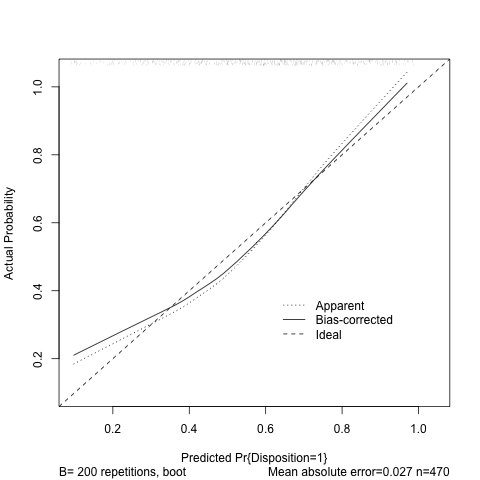

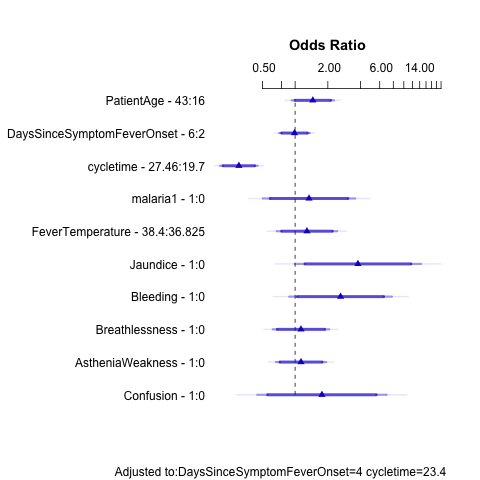

In [64]:
%%R -i reft_folder,reft_vars



saveModelToCSV <- function(f, vars, dir) {
    terms = names(f$coefficients)
    coeff = unname(f$coefficients)

    # Extract RCS knots from model specs. 
    # This code is now specific to get the knots for age and fever temperature, 
    # but it could be generalized easily by providing a list with all the 
    # variables modeled as RCS.
    
    spec = specs(f)
    # print(str(spec)) # This is useful to understand the structure of the object
    
    ageIdx <- which(vars == "PatientAge")
    tempIdx <- which(vars == "FeverTemperature")
    ageKnots <- spec$how.modeled[ageIdx, 2]
    tempKnots <- spec$how.modeled[tempIdx, 2]
    ageKnots <- trim(ageKnots)
    tempKnots <- trim(tempKnots)

    print(spec$how.modeled)
    print(tempIdx)
    
    types <- rep.int("linear", length(terms))
    knots = rep.int("none", length(terms))

    age0 <- which(terms == "PatientAge")
    age1 <- which(terms == "PatientAge'")

    temp0 <- which(terms == "FeverTemperature")
    temp1 <- which(terms == "FeverTemperature'")

    types[age0] <- "RCS0"
    types[age1] <- "RCS1"
    knots[age1] <- ageKnots

    types[temp0] <- "RCS0"
    types[temp1] <- "RCS1"
    knots[temp1] <- tempKnots

    model <- data.frame("Term" = terms, "Coefficient" = coeff, "Type" = types, "Knots" = knots)
    write.table(model, file = paste0(dir, "/model.csv"), sep = ",", row.names=FALSE, qmethod = "double")    
}




saveDescription(f=reft_model, vars=reft_vars, dir=reft_folder)
saveEvaluation(an=reft_anova, val=reft_val, cal=reft_cal, dir=reft_folder)

options(datadist='reft_datadist')
dir <- reft_folder
df <- getImpute(impute=reft_impute, im=1)
f <- reft_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()
                                           
plot(summary(f), log=TRUE)

It is interesting to note that the coefficient for the referral-time-CT interaction term is b=-0.00104, while the coefficient for the linear referral-time term is a=0.021, i.e.: a=-20*b. In fact, Hartley's model assumes that the interaction is of the form c*(CT-20)*RT (RT denotes referral-time) for some negative c. This factorizes as c*CT-20*c*RT, which is consistent with the coefficients we obtain in our model for the corresponding terms. However, the coefficient is very small to have a significant impact on the calculated risks.